In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import precision_recall_fscore_support

data= fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])

In [6]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]
    
    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [7]:
from sklearn.linear_model import LogisticRegression
logReg_clf = LogisticRegression(penalty = "l2",#"l1","elasticnet",None
                                C=10,#inverse of regularization strength, smaller -> stronger
                                solver = 'lbfgs'
#                                 l1_ratio=0.2 #1 is pure l1 and 0 is pure l2
                                )

In [8]:
from sklearn.model_selection import cross_validate

results = cross_validate(logReg_clf,
                         X = X_train,
                         y=y_train,
                        scoring = ["accuracy","roc_auc_ovr_weighted","f1_macro"],
                         
                         #macro - unweighted mean of metrics per label
                         #weighted - weighted mean of metrics per label based on support
                         #Full list of scoring metrics can be found here 
                         #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                         
                        cv = 5,#If our estimator is classifier automatically do stratified CV
                        n_jobs=-1,#Num CPUs to use for calculation, -1 means all
                        verbose = True,#Output status updates
                        return_train_score=True,
                        return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/maxschallwig/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 19.7min finished


In [6]:
results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr_weighted', 'train_roc_auc_ovr_weighted', 'test_f1_macro', 'train_f1_macro'])

In [7]:
results["estimator"]

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 Log

In [8]:
print(np.mean(results["test_f1_macro"]))

#Variation in our predictions
print(np.std(results["test_f1_macro"]))

0.9157926241724293
0.002366831077225779


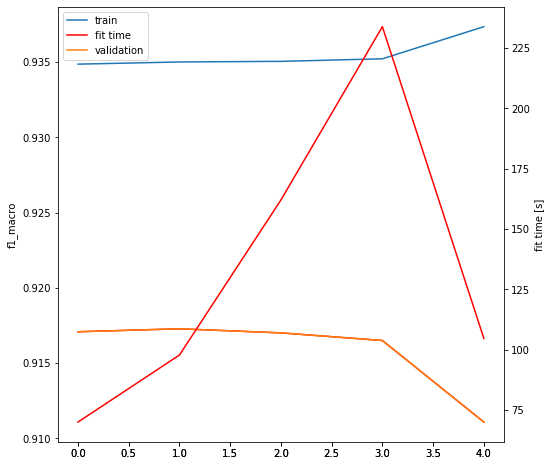

In [9]:
cvData = {"val":results["test_f1_macro"],
        "train":results["train_f1_macro"],
        "fit_time":results["fit_time"]}

dfCV = pd.DataFrame(cvData).sort_values("train").reset_index(drop=True)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.plot(dfCV.index,dfCV["train"],label="train")
ax.plot(dfCV.index,dfCV["val"],color="red",label="fit time")
plt.plot(dfCV.index,dfCV["val"],label='validation')
plt.ylabel("f1_macro")
plt.legend()

ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
ax2.plot(dfCV.index,dfCV["fit_time"],color="red",label="fit time")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('fit time [s]')

plt.show()

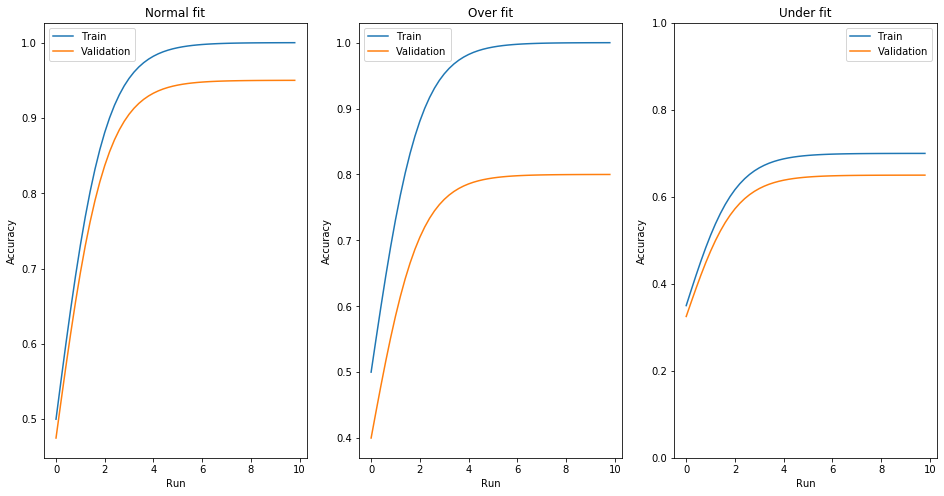

In [10]:
x = np.arange(0,10,.2)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(131)
plt.title("Normal fit")
plt.plot(x,1/(1+np.exp(-x)),label="Train")
plt.ylabel("Accuracy")
plt.xlabel("Run")
plt.plot(x,0.95/(1+np.exp(-x)),label="Validation")
plt.legend()
fig.add_subplot(132)
plt.title("Over fit")
plt.plot(x,1/(1+np.exp(-x)),label="Train")
plt.ylabel("Accuracy")
plt.xlabel("Run")
plt.plot(x,0.8/(1+np.exp(-x)),label="Validation")
plt.legend()

fig.add_subplot(133)
plt.title("Under fit")
plt.plot(x,.7/(1+np.exp(-x)),label="Train")
plt.ylabel("Accuracy")
plt.xlabel("Run")
plt.plot(x,0.65/(1+np.exp(-x)),label="Validation")
plt.legend()

plt.ylim(0,1)
plt.show()

In [11]:
results["estimator"][1].predict(X_train)

array(['7', '0', '6', ..., '5', '4', '5'], dtype=object)